# Simple Rocket Soft-Landing Problem with SOCP Constraints

This notebook is a walkthough of the ALTRO solver for the (linear) Rocket Soft-Landing Problem (i.e. the general control challenge of landing a rocket at rest at a designated landing site). In the simplest case, we treat the rocket as a sphere landing on a flat surface with no atmosphere. This approximation is reasonable when the rocket is near the ground and entering the final part of the descent.

**This files focuses on the problem set-up and visualizing the result. For the MPC application, please visit the <code>RocketLandingMPC.ipynb</code> file. Thanks!**

In [1]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.status()

 Activating environment at `C:\Users\Daniel N\.julia\dev\altro-mpc-icra2021\benchmarks\rocket_landing\Project.toml`

Status `C:\Users\Daniel N\.julia\dev\altro-mpc-icra2021\benchmarks\rocket_landing\Project.toml`


  [5dcf52e5] Altro v0.2.0 #socp (https://github.com/RoboticExplorationLab/Altro.jl.git)
  [6e4b80f9] BenchmarkTools v0.5.0
  [f65535da] Convex v0.13.7
  [0c46a032] DifferentialEquations v6.15.0
  [e2685f51] ECOS v0.12.1
  [5789e2e9] FileIO v1.4.3
  [283c5d60] MeshCat v0.11.3
  [7269a6da] MeshIO v0.3.2
  [91a5bcdd] Plots v1.6.9
  [d330b81b] PyPlot v2.9.0
  [38ceca67] RobotDynamics v0.2.2
  [6038ab10] Rotations v1.0.1
  [90137ffa] StaticArrays v0.12.4
  [7770976a] TrajOptPlots v0.1.0 #master (https://github.com/RoboticExplorationLab/TrajOptPlots.jl)
  [c79d492b] TrajectoryOptimization v0.3.2 #socp (https://github.com/RoboticExplorationLab/TrajectoryOptimization.jl.git)
  [37e2e46d] LinearAlgebra 
  [2f01184e] SparseArrays 


## Load Required Packages

The <code>RobotDynamics</code> package enables us to define the rocket model and dynamics. The <code>TrajectoryOptimization</code> and <code>Altro</code> set-up and solve the trajectory optimization problem. <code>StaticArrays</code> and <code>LinearAlgebra</code> are required to set-up the appropriate data types.

Next, <code>Plots, MeshCat, TrajOptPlots, FileIO,</code> and <code>MeshIO</code> packages are used to visualize the results. Note that the plotting sections will take significantly longer to run than the optimization. 

Lastly, <code>DifferentialEquations</code> integrates the dynamics forward as a way to show that the dynamics constraints are satisfied.

Loading all the packages, especially for plotting and the differential equations integrator can be the longest part of the whole notebook.

In [2]:
using RobotDynamics
import RobotDynamics: dynamics
using Rotations
using Altro
using TrajectoryOptimization
using StaticArrays, LinearAlgebra
println("Trajectory Optimization Packages Ready")

using Plots
pyplot()
println("Base Plotting Packages Ready")

using MeshCat, TrajOptPlots
using FileIO, MeshIO
println("3D Plotting Packages Ready")

import DifferentialEquations.solve, DifferentialEquations.ODEProblem, DifferentialEquations.Tsit5
using BenchmarkTools
println("Differential Equations Ready")

Trajectory Optimization Packages Ready
Base Plotting Packages Ready
3D Plotting Packages Ready
Differential Equations Ready


## Detail the Rocket Dynamics

For the simplified rocket problem, we choose to ignore the attitude dynamics. Applying newton's second law or by forming a Lagrangian, we arrive at the following sparse system

$$\frac{dx}{dt} = Ax + Bu + g$$

Where $A = \begin{bmatrix}0 & I\\ 0 & 0 \end{bmatrix}$, $B = \begin{bmatrix}0 \\ \frac{1}{m} I\end{bmatrix}$, and $G = \begin{bmatrix} 0 \\ -g \end{bmatrix}$. For the 3D case, these are $(6 \times 6)$, $(6 \times 3)$, and $(6 \times 1)$ matricies, respectively.

Since the system is so sparse, we can reduce unnecessary computations by writing the equations for the first and second derivatives. We use the notation of $s = [x; y; z]$ (the positions) and $\frac{ds}{dt} = [v_x; v_y; v_z]$ (the velocities). 

In [3]:
const mass = 10.0
const grav = SA[0.0; 0.0; -9.81]

model = LinearModel([zeros(3,3) I; zeros(3, 6)], [zeros(3,3); (1/mass) * I], vec([zeros(3, 1); grav]))

LinearModel{6,3,Float64,15}(SizedArray{Tuple{6,6},Float64,2,2}[[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]], SizedArray{Tuple{6,3},Float64,2,2}[[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.1 0.0; 0.0 0.0 0.1]], SizedArray{Tuple{6},Float64,1,1}[[0.0, 0.0, 0.0, 0.0, 0.0, -9.81]], Float64[], 0.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], true)

## Instantiate the Model and Define the Discretization

Feel free to choose <code>N</code> and <code>tf</code> based on your needs.

In [4]:
n, m = size(model)
# n is the size of the states ([x, y, z, vx, vy, vz])
# m is the size of the control thrust ([Tx, Ty, Tz]])

# Trajectory Discretization
N = 251
tf = 10.
dt = tf/(N-1)

model # (Simply for information) Display the struct as the cell output 

LinearModel{6,3,Float64,15}(SizedArray{Tuple{6,6},Float64,2,2}[[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 1.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]], SizedArray{Tuple{6,3},Float64,2,2}[[0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.1 0.0; 0.0 0.0 0.1]], SizedArray{Tuple{6},Float64,1,1}[[0.0, 0.0, 0.0, 0.0, 0.0, -9.81]], Float64[], 0.0, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], true)

## Specify the Initial and Final Conditions

Choose the initial and final points. Note that these must be full state vectors ($[x; y; z; v_x; v_y; v_z]$). The initial point is generally the rocket's current state. The final point is generally the rocket's landing stop. Note that the final velocity of the rocket should **always** be $[0.0; 0.0; 0.0]$ to have a **soft** landing.

In [5]:
# Initial and Final Conditions
x0 = @SVector [4.0, 2.0, 20.0, -3.0, 2.0, -5.0] # Start at a 20 m altitude with an ~15 m/s plummet
xf = @SVector zeros(n);  # Swing pendulum up and end at rest

## Set-Up the LQR Objective Function

For this problem, we choose an LQR Objective Function. One can add waypoints or change the weights to craft different optimal trajectories. See http://roboticexplorationlab.org/TrajectoryOptimization.jl/stable/costfunctions.html for more information.

In [6]:
Q = 1.0e-2 * Diagonal(@SVector ones(n))
Qf = 100.0 * Diagonal(@SVector ones(n))
R = 1.0e-1 * Diagonal(@SVector ones(m))
obj = LQRObjective(Q,R,Qf,xf,N)

Objective

## Define the Constraints

For the simple rocket soft-landing problem, we will include 4 constraints:
1. Landing Site Designation ($x[t_f] = x_f$)
2. Crash Prevention Constraint ($z > 0$)
3. Maximum Thrust Constraint ($0 < ||u|| < u_{max}$), which is a simplification of a max thrust constraint
4. Maximum Thurst Angle Constraint ($||[u_x; u_y]|| ≤ \alpha \ u_z$), which is a simplification of a max thrust angle constraint 

For details on the implemented constraint types, please check out http://roboticexplorationlab.org/TrajectoryOptimization.jl/stable/constraints.html.

In [7]:
# Create Empty ConstraintList
conSet = ConstraintList(n,m,N)

# Key Constants
ground_level = 0.0 # Crash Prevention Constraint
theta = 7 # deg. Max Angle Constraint
perWeightMax = 2
u_bnd = mass * norm(grav[3]) * perWeightMax
println("Maximum Thrust is $u_bnd")


# Goal Constraint that the rocket must reach the landing site.
goal = GoalConstraint(xf)
add_constraint!(conSet, goal, N)

# Bounds
bnd = BoundConstraint(n,m, x_min=[-Inf, -Inf, ground_level,
                                  -Inf, -Inf, -Inf])

# Include the max thrust constraint
maxT = NormConstraint(n, m, u_bnd, TrajectoryOptimization.SecondOrderCone(), :control)
add_constraint!(conSet, maxT, 1:N-1)

# Include the max thrust angle constraint
function getAlpha(theta, deg = true)
    if deg
        return tand(theta)
    end
    return tan(theta)
end


maxTAalpha = getAlpha(theta)

Maximum Thrust is 196.20000000000002


0.1227845609029046

In [8]:
# struct NormConstraint2{S,D,p,q} <: TrajectoryOptimization.ControlConstraint #TrajectoryOptimization.StageConstraint 
#     n::Int
#     m::Int
#     A::SizedMatrix{p, q, Float64, 2}
#     c::SVector{p, Float64}
#     sense::S
#     inds::SVector{D,Int}
#     function NormConstraint2(n::Int, m::Int, A::SizedMatrix, c::SVector, sense::TrajectoryOptimization.ConstraintSense,
#             inds = SVector{m}(1:m))
#         if inds == :control
#             inds = SVector{m}(1:m)
#         end
#         @assert size(A,2) == length(c)
#         @assert eltype(A) == eltype(c)
        
#         display(inds)

#         new{typeof(sense),length(inds), size(A, 1), size(A, 2)}(n,m,A,c,sense,inds)
#     end
# end

# @inline TrajectoryOptimization.state_dim(con::NormConstraint2) = con.n
# @inline TrajectoryOptimization.control_dim(con::NormConstraint2) = con.m
# @inline TrajectoryOptimization.sense(con::NormConstraint2) = con.sense
# # @inline Base.length(::NormConstraint2) = 1
# @inline Base.length(::NormConstraint2{TrajectoryOptimization.SecondOrderCone,D}) where D = D + 1

# function TrajectoryOptimization.evaluate(con::NormConstraint2{TrajectoryOptimization.SecondOrderCone}, z::AbstractKnotPoint)
#     v = con.A*z.z[con.inds]
#     return push(v, con.c'*z.z[con.inds])
# end

# function TrajectoryOptimization.jacobian!(∇c, con::NormConstraint2{TrajectoryOptimization.SecondOrderCone}, 
#                                                     z::AbstractKnotPoint)
# #     display(con)
# #     display(con.inds)
#     ∇c[1:length(con.inds),con.inds] = con.A
#     ∇c[1+length(con.inds),con.inds] = con.c
#     return true
# end

# function TrajectoryOptimization.change_dimension(con::NormConstraint2, n::Int, m::Int, ix=1:n, iu=1:m)
#     NormConstraint2(n, m, con.val, con.sense, ix[con.inds])
# end

In [9]:
struct NormConstraint2{S,D,p,q} <: TrajectoryOptimization.StageConstraint 
    n::Int
    m::Int
    A::SizedMatrix{p, q, Float64, 2}
    c::SVector{p, Float64}
    sense::S
    inds::SVector{D,Int}
    function NormConstraint2(n::Int, m::Int, A::SizedMatrix, c::SVector, sense::TrajectoryOptimization.ConstraintSense,
            inds = SVector{m}(1:m))
        if inds == :control
            inds = SVector{m}(n .+ (1:m))
        end
        @assert size(A,2) == length(c)
        @assert eltype(A) == eltype(c)
        
        display(inds)

        new{typeof(sense),length(inds), size(A, 1), size(A, 2)}(n,m,A,c,sense,inds)
    end
end

@inline TrajectoryOptimization.state_dim(con::NormConstraint2) = con.n
@inline TrajectoryOptimization.control_dim(con::NormConstraint2) = con.m
@inline TrajectoryOptimization.sense(con::NormConstraint2) = con.sense
# @inline Base.length(::NormConstraint2) = 1
@inline Base.length(::NormConstraint2{TrajectoryOptimization.SecondOrderCone,D}) where D = D + 1

function TrajectoryOptimization.evaluate(con::NormConstraint2{TrajectoryOptimization.SecondOrderCone}, z::AbstractKnotPoint)
    v = con.A*z.z[con.inds]
    return push(v, con.c'*z.z[con.inds])
end

function TrajectoryOptimization.jacobian!(∇c, con::NormConstraint2{TrajectoryOptimization.SecondOrderCone}, 
                                                    z::AbstractKnotPoint)
#     display(con)
#     display(con.inds)
    ∇c[1:length(con.inds),con.inds] = con.A
    ∇c[1+length(con.inds),con.inds] = con.c
    return true
end

function TrajectoryOptimization.change_dimension(con::NormConstraint2, n::Int, m::Int, ix=1:n, iu=1:m)
    NormConstraint2(n, m, con.val, con.sense, ix[con.inds])
end

In [10]:
ARocket = SizedMatrix{3,3}([1.0 0 0; 0 1.0 0; 0 0 0])
cRocket = SVector{3}([0; 0; maxTAalpha])

display(eltype(ARocket))
display(eltype(cRocket))

maxTA = NormConstraint2(n, m, ARocket, cRocket, TrajectoryOptimization.SecondOrderCone(), :control)
add_constraint!(conSet, maxTA, 1:N-1)
maxTA

Float64

Float64

3-element SArray{Tuple{3},Int64,1,3} with indices SOneTo(3):
 7
 8
 9

NormConstraint2{TrajectoryOptimization.SecondOrderCone,3,3,3}(6, 3, [1.0 0.0 0.0; 0.0 1.0 0.0; 0.0 0.0 0.0], [0.0, 0.0, 0.1227845609029046], TrajectoryOptimization.SecondOrderCone(), [7, 8, 9])

In [11]:
n .+ (1:m)

7:9

In [12]:
1:n

1:6

In [13]:
TrajectoryOptimization.widths(maxTA, n, m)

(9,)

## Stitch together the objective and constraints

See http://roboticexplorationlab.org/TrajectoryOptimization.jl/stable/creating_problems.html for more information.

In [14]:
# Package the objective and constraints into a "problem" type
prob = Problem(model, obj, xf, tf, x0=x0, constraints=conSet);

## Initialize the Trajectory

We choose to initialize the trajectory at a hover (i.e. the rocket trajectory will initially only counter gravity).

In [15]:
u0 = grav # controls that would nominally hover
U0 = [u0 for k = 1:N-1] # vector of the small controls
initial_controls!(prob, U0)
rollout!(prob);

## Select the solver options

For more information, please visit https://github.com/RoboticExplorationLab/Altro.jl/blob/master/README.md for more details on the solver options.

Using the Altro package, we can now specify parameters and solve the problem.

In [16]:
opts = SolverOptions(
    cost_tolerance_intermediate=1e-2,
    penalty_scaling=10.,
    penalty_initial=1.0,
    verbose = 1,
    projected_newton = false
)

SolverOptions{Float64}
  constraint_tolerance: Float64 1.0e-6
  cost_tolerance: Float64 0.0001
  cost_tolerance_intermediate: Float64 0.01
  gradient_tolerance: Float64 10.0
  gradient_tolerance_intermediate: Float64 1.0
  iterations_inner: Int64 300
  dJ_counter_limit: Int64 10
  square_root: Bool false
  line_search_lower_bound: Float64 1.0e-8
  line_search_upper_bound: Float64 10.0
  iterations_linesearch: Int64 20
  max_cost_value: Float64 1.0e8
  max_state_value: Float64 1.0e8
  max_control_value: Float64 1.0e8
  static_bp: Bool true
  save_S: Bool false
  bp_reg: Bool false
  bp_reg_initial: Float64 0.0
  bp_reg_increase_factor: Float64 1.6
  bp_reg_max: Float64 1.0e8
  bp_reg_min: Float64 1.0e-8
  bp_reg_type: Symbol control
  bp_reg_fp: Float64 10.0
  penalty_initial: Float64 1.0
  penalty_scaling: Float64 10.0
  active_set_tolerance_al: Float64 0.001
  dual_max: Float64 NaN
  penalty_max: Float64 NaN
  iterations_outer: Int64 30
  kickout_max_penalty: Bool false
  reset_duals:

Show summary is set to <code>true</code> to print the solver speed. In general the solve will take about 23 iterations and 20-30 ms to complete. The constraint violation should be around $10^{-4}$ or better.

In [17]:
altro = ALTROSolver(prob, opts);

In [18]:
set_options!(altro, show_summary=false)
b = benchmark_solve!(altro)

BenchmarkTools.Trial: 
  memory estimate:  44.56 MiB
  allocs estimate:  317303
  --------------
  minimum time:     78.955 ms (10.06% GC)
  median time:      90.054 ms (10.24% GC)
  mean time:        92.526 ms (10.45% GC)
  maximum time:     110.225 ms (10.63% GC)
  --------------
  samples:          6
  evals/sample:     10

In [19]:
set_options!(altro, show_summary=true)
solve!(altro);


SOLVE COMPLETED
 solved using the ALTRO Solver,
 part of the Altro.jl package developed by the REx Lab at Stanford and Carnegie Mellon Universities

  Solve Statistics
    Total Iterations: 14
    Solve Time: 151.84110099999998 (ms)

  Covergence
    Terminal Cost: 5343.0794766380395
    Terminal dJ: 8.6392947506356
    Terminal gradient: 0.0086131226192018
    Terminal constraint violation: 4.468232998842969e-7
    Solve Status: SOLVE_SUCCEEDED


## Access the Trajectory

In [20]:
X = states(altro)
U = controls(altro)

xs = [x[1] for x in X]
zs = [x[3] for x in X]

uxs = [u[1] for u in U]
uys = [u[2] for u in U]
uzs = [u[3] for u in U]

250-element Array{Float64,1}:
 105.65067394317282
 105.63409597520003
 105.6172201582361
 105.60004983592529
 105.58258849419957
 105.56483902614775
 105.5468050741143
 105.52848977428117
 105.51433764039709
 105.50560138976392
 105.49658651875515
 105.48729602160626
 105.47773287317672
   ⋮
 100.1963925377465
 100.16915586455775
 100.14192223618514
 100.11469165820974
 100.08746413099017
 100.06023964973237
 100.03301820455921
 100.00579978058026
  99.97858435796125
  99.95137191199404
  99.92416241316594
  99.89695582722958

## Plot the trajectory!

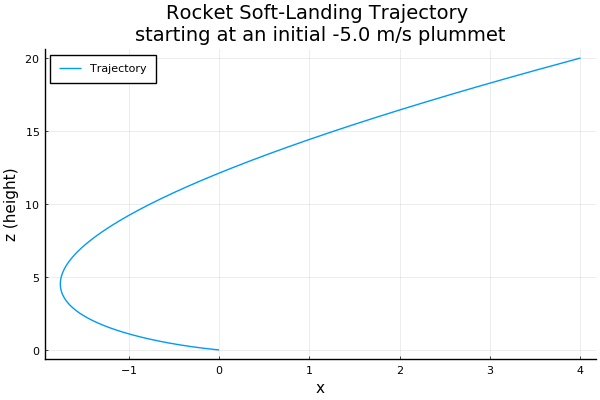

In [21]:
titleText = "Rocket Soft-Landing Trajectory \n" *
        "starting at an initial $(x0[6]) m/s plummet"
filename = "RocketGroundThrustBound_BarelyFeasible3"

plt_x = plot(xs, zs, label = "Trajectory")
xlabel!("x")
ylabel!("z (height)")
title!(titleText)

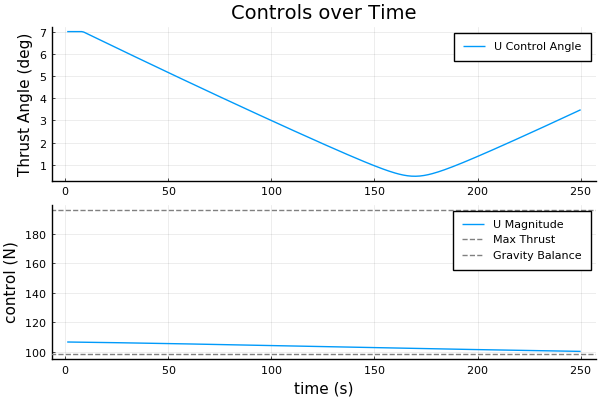

In [22]:
function getAngle3D(u)
    if norm(u[3]) == 0.0
        # hit the tan singularity
        return pi / 2
    else
        return atand(norm([u[1]; u[2]]), u[3])
    end
end

plt_ux = plot(getAngle3D.(U), label = "U Control Angle")
# hline!([-ulateral_max, ulateral_max], linecolor = :grey, linestyle = :dash,
#                 label = "Max Lateral Thrust")
# xlabel!("time (s)")
ylabel!("Thrust Angle (deg)")
title!("Controls over Time")

plt_umag = plot(norm.(U), label = "U Magnitude")
hline!([u_bnd], linecolor = :grey, linestyle = :dash, label = "Max Thrust")
hline!([norm(mass * grav[3])], linecolor = :grey, linestyle = :dash, label = "Gravity Balance")
xlabel!("time (s)")
ylabel!("control (N)")

plt_u = plot(plt_ux, plt_umag, layout = (2, 1))

Below is a GIF of the trajectory. This will take several seconds to generate.

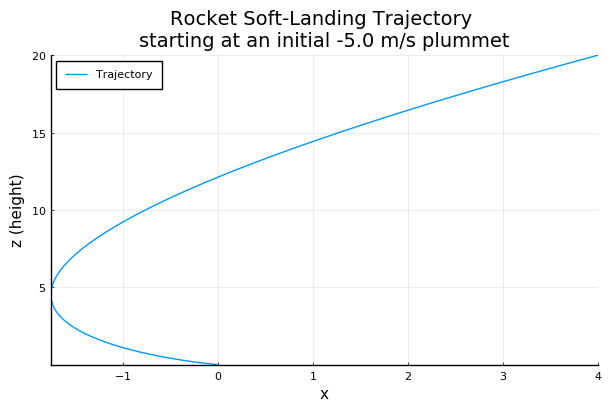

┌ Info: Saved animation to 
│   fn = C:\Users\Daniel N\.julia\dev\altro-mpc-icra2021\benchmarks\rocket_landing\tmp.gif
└ @ Plots C:\Users\Daniel N\.julia\packages\Plots\a7Kbp\src\animation.jl:104


Plots.AnimatedGif("C:\\Users\\Daniel N\\.julia\\dev\\altro-mpc-icra2021\\benchmarks\\rocket_landing\\tmp.gif")
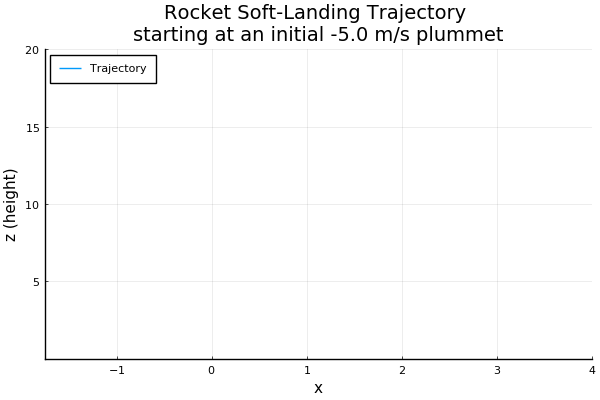

In [23]:
xmin = minimum(xs)
xmax = maximum(xs)

zmin = minimum(zs)
zmax = maximum(zs)

@gif for i in 1:N
    plt = plot(xs[1:i], zs[1:i], label = "Trajectory", legend = :topleft)
    xlabel!("x")
    ylabel!("z (height)")
    xlims!(xmin,xmax)
    ylims!(zmin,zmax)
    title!(titleText)
end

## Lastly, let's visualize the results in 3D with Meshcat

To do this, we need to provide a Mesh to <code>MeshCat</code>. This is due with <code>FileIO</code> and <code>MeshIO</code>.

In [24]:
vis = Visualizer() # Creates a MeshCat Window
render(vis) # Renders the window below

┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://localhost:8701
└ @ MeshCat C:\Users\Daniel N\.julia\packages\MeshCat\X2AUA\src\visualizer.jl:73


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String,Array{UInt8,1}}(), nothing, Dict{String,MeshCat.SceneTrees.SceneNode}()), Set(Any[]), ip"127.0.0.1", 8701))

In [25]:
function TrajOptPlots._set_mesh!(vis, model::LinearModel)
    obj = joinpath(@__DIR__, "SimpleRocket.obj")
    quad_scaling = 0.085
    robot_obj = FileIO.load(obj)
    robot_obj.vertices .*= quad_scaling
    mat = MeshPhongMaterial(color=colorant"lightgrey")
    setobject!(vis["geom"], robot_obj, mat)
end

TrajOptPlots.set_mesh!(vis, model)

MeshCat Visualizer with path /meshcat/robot/geom at http://localhost:8701

In [26]:
Base.position(::LinearModel, x::StaticVector) = SA[x[1], x[2], x[3]]
RobotDynamics.orientation(::LinearModel, x::StaticVector) = UnitQuaternion(0,0,0,1)

visualize!(vis, altro);

## Integrate the Dynamics to Verify the Dynamics Constraint

In Matlab, we would use ODE 45, but in the <code>DifferentialEquations.jl</code> package we can either (1) just let the <code>solve</code> method figure it out or (2) specify a solver such as <code>Tsit5</code>.

The controls change over time and are discretized. Below, a zero-order hold and a first-order hold are implemented for comparison. **We used a zero-order hold in the optimization so a zero-order hold should be used here.**

In [27]:
get_controls_zero_order_hold(t) = U[min(Int(floor(t/dt)) + 1, size(U,1))]
f(y,p,t) = dynamics(model, y, get_controls_zero_order_hold(t))

states_y0 = x0
tspan = (0.0, tf)
controls_p0 = get_controls_zero_order_hold(tspan[1])

ode_prob_zoh = ODEProblem(f, states_y0, tspan, controls_p0)
@btime solve(ode_prob_zoh, Tsit5(), reltol=1e-10, abstol=1e-10,saveat=dt)
ode_sol_zoh = solve(ode_prob_zoh, Tsit5(), reltol=1e-10, abstol=1e-10,saveat=dt);

  247.144 ms (2114626 allocations: 80.28 MiB)


In [28]:
function get_controls_first_order_hold(t)
    # dt and U are both global variables
    tn = t/dt
    
    t_below = Int(max(1, floor(tn)))
    t_above = Int(min(size(U, 1), ceil(tn)))
    
    if t_below >= t_above
        return U[t_below]
    end
    
    slope = (U[t_above] - U[t_below])
    return slope * (tn - t_below) + U[t_below]

end


f(y,p,t) = dynamics(model, y, get_controls_first_order_hold(t))

states_y0 = x0
tspan = (0.0, tf)
controls_p0 = get_controls_first_order_hold(tspan[1])

ode_prob_foh = ODEProblem(f, states_y0, tspan, controls_p0)
@btime solve(ode_prob_foh, Tsit5(), reltol=1e-10, abstol=1e-10,saveat=dt)
ode_sol_foh = solve(ode_prob_foh, Tsit5(), reltol=1e-10, abstol=1e-10,saveat=dt);

  13.129 ms (130981 allocations: 4.55 MiB)


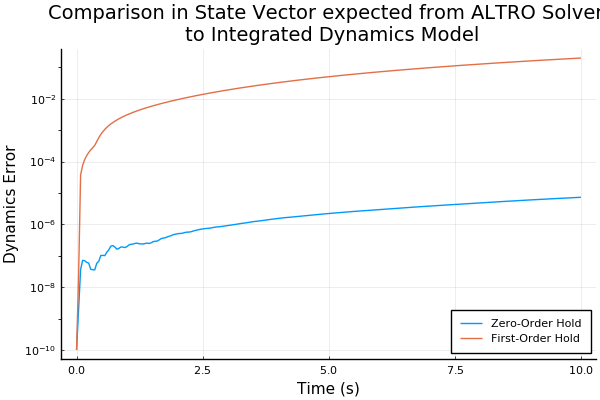

In [29]:
err_zoh = norm.(ode_sol_zoh.u - X[1:(Int(tspan[2]/dt)+1)])
err_foh = norm.(ode_sol_foh.u - X[1:(Int(tspan[2]/dt)+1)])

bound = 10^(-10)

plot(ode_sol_zoh.t, max.(bound, err_zoh), yaxis = :log, label = "Zero-Order Hold")
plot!(ode_sol_foh.t, max.(bound, err_foh), yaxis = :log, label = "First-Order Hold")
xlabel!("Time (s)")
ylabel!("Dynamics Error")
title!("Comparison in State Vector expected from ALTRO Solver \n to Integrated Dynamics Model")